# Hybrid Search RAG with LLamaIndex + RAGAS Eval

This notebook provides a walk-through of:
- Building hybrid search RAG with LlamaIndex and Opensearch.
    - Loading and indexing data to a vector store.
    - Setup hybrid retrieval QueryEngine.
- Evaluating Hybrid Search retrieval performance with RAGAS.


### Run Opensearch
To perform hybrid search, we will need a datastore that can support both text and vector indices. I will be using Opensearch in this walk-through.

Run the following docker command to start a local Opensearch instance. Update or omit the volume mount according to your needs.
```sh
docker run \
    -p 9200:9200 -p 9600:9600 \
    -e "discovery.type=single-node" -e "plugins.security.disabled=true" \
    -v ./persist/opensearch:/usr/share/opensearch/data \
    opensearchproject/opensearch:2.11.1 
```



In [1]:
# install packages
%pip install --quiet beautifulsoup4==4.12.2 \
    httpx==0.25.2 \
    html2text==2020.1.16 \
    llama-index==0.9.15.post2 \
    python-dotenv==1.0.0 \
    pandas==2.1.4 \
    nest-asyncio==1.5.8 \
    ragas==0.0.22 \
    matplotlib==3.8.2

Note: you may need to restart the kernel to use updated packages.


In [1]:
from os import getenv
from dotenv import load_dotenv

%load_ext autoreload
%autoreload 2

# OPENAI_API_KEY is defined on a local .env file
load_dotenv(override=True)

# constants to be used throughout this notebook
OPENSEARCH_ENDPOINT = getenv("OPENSEARCH_ENDPOINT", "http://localhost:9200")
OPENSEARCH_INDEX = getenv("OPENSEARCH_INDEX", "hdb-buying-a-flat")
OPENSEARCH_TEXT_FIELD = "content"
OPENSEARCH_EMBEDDNG_FIELD = "embedding"
EMBEDDING_DIMENSIONS = 1536 # text-embedding-ada-002
CHUNK_SIZE = 512
CHUNK_OVERLAP = 0
RETRIEVE_TOP_K = 5
DEFAULT_SEARCH_PIPELINE = "hybrid-search-pipeline-0.5"

## 1. Building the Hybrid Search Indices
### 1.1. Initialize Opensearch vector store client

In [2]:
from llama_index import StorageContext
from llama_index.embeddings import OpenAIEmbedding
from llama_index.embeddings.openai import OpenAIEmbeddingMode, OpenAIEmbeddingModelType
from llama_index.ingestion import IngestionPipeline
from llama_index.text_splitter import SentenceSplitter
from llama_index.vector_stores import OpensearchVectorStore, OpensearchVectorClient

# http endpoint for your cluster (opensearch required for vector index usage)
endpoint = OPENSEARCH_ENDPOINT

# index to demonstrate the VectorStore impl
idx = OPENSEARCH_INDEX

# OpensearchVectorClient stores text in this field by default
text_field = OPENSEARCH_TEXT_FIELD

# OpensearchVectorClient stores embeddings in this field by default
embedding_field = OPENSEARCH_EMBEDDNG_FIELD

# Dimensions for text-embedding-ada-002 embedding model
dimensions = EMBEDDING_DIMENSIONS

# Opensearch uses this to combine retrieval from text and embedding fields
search_pipeline = DEFAULT_SEARCH_PIPELINE

# OpensearchVectorClient encapsulates logic for a
# single opensearch index with vector search enabled
client = OpensearchVectorClient(
    endpoint,
    idx,
    dimensions,
    embedding_field=embedding_field,
    text_field=text_field,
    search_pipeline=DEFAULT_SEARCH_PIPELINE,
)

# initialize vector store
vector_store = OpensearchVectorStore(client)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

### 1.2. Initialize ingestion pipeline

In [3]:
# create the pipeline with transformations
# - chunk size can be modified based on your data
# - use OpenAI embeddings
pipeline = IngestionPipeline(
    transformations=[
        SentenceSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP),
        OpenAIEmbedding(
            OpenAIEmbeddingMode.SIMILARITY_MODE,
            OpenAIEmbeddingModelType.TEXT_EMBED_ADA_002,
        ),
    ],
)

### 1.3 Load data and build index

In [4]:
# a custom script to crawl, extract text content from HDB website to ingest to datastore.
from utils.crawl import Crawler

crawler = Crawler(pipeline, vector_store)

base_url = "https://www.hdb.gov.sg"
seed_urls = [
    "https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan-options"
]

crawler.crawl(base_url=base_url, seed_urls=seed_urls)

[OK] url: https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan-options
[OK] url: https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan-options/housing-loan-options
[OK] url: https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan-options/application-for-an-hdb-flat-eligibility-hfe-letter
[OK] url: https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan-options/flat-and-grant-eligibility
[OK] url: https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan-options/housing-loan-options/housing-loan-from-hdb
[OK] url: https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan-options/housing-loan-options/housing-loan-from-financial-institutions
[OK] url: https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan

A sample snippet of code for adding a text and embedding data to data store from `utils/crawl.py`

```python

# extract text content from web page
text = ...

# create document with <title, url> metadata
metadata = {
    "title": "example",
    "url": "https://example.com",
}
document = Document(text=text, metadata=metadata)

# run pipeline that chunks and create embedding from given Document
nodes = self.pipeline.run(documents=[document])

# add nodes to Opensearch index
self.vector_store.add(nodes)
```


## 2. Querying from Hybrid Datastore 

### 2.1 Create a search pipeline in Opensearch
Before we can perform hybrid search with Opensearch, we need to define a search pipeline.
The search pipeline allows us to configure how the retrieved chunks from the text and vector store are weighted.

More info about Opensearch search pipeline can be found here [here](https://opensearch.org/docs/latest/search-plugins/hybrid-search/#step-4-configure-a-search-pipeline)

In [2]:
# Create search pipeline for hybrid query
import requests

def create_opensearch_search_pipeline(pipeline_name, alpha):
    """
    Create an Opensearch search pipeline

    Parameters:
    pipeline_name (str): Name of the pipeline.
    alpha: Weight of vector search. alpha of 0 is pure bm25 and an alpha of 1 is pure vector search.
    """

    if alpha < 0 or alpha > 1:
        print(f"alpha must be >= 0 and <= 1")
        return
    alpha *= 1.0
    headers = {
        "Content-Type": "application/json",
    }

    json_data = {
        "description": "Post processor for hybrid search",
        "phase_results_processors": [
            {
                "normalization-processor": {
                    "normalization": {
                        "technique": "l2",
                    },
                    "combination": {
                        "technique": "arithmetic_mean",
                        "parameters": {
                            "weights": [
                                1.0 - alpha,  # text field weight
                                alpha,  # embedding field weight
                            ],
                        },
                    },
                },
            },
        ],
    }

    response = requests.put(
        f"http://localhost:9200/_search/pipeline/{pipeline_name}",
        headers=headers,
        json=json_data,
    )
    if response.status_code == 200:
        print(f"created opensearch search pipeline [{pipeline_name}]")
    else:
        print(f"failed to create opensearch search pipeline [{pipeline_name}]")

In [5]:
create_opensearch_search_pipeline(DEFAULT_SEARCH_PIPELINE, 0.5)

created opensearch search pipeline [hybrid-search-pipeline-0.5]


### 2.2 Create Query Engine 
Query engine is a generic interface that allows you to ask question over your data.

A query engine takes in a natural language query, and returns a rich response.

Learn more info about LlamaIndex's Query Engine [here](https://docs.llamaindex.ai/en/stable/module_guides/deploying/query_engine/root.html)

In [6]:
from llama_index import VectorStoreIndex, get_response_synthesizer
from llama_index.retrievers import VectorIndexRetriever
from llama_index.query_engine import RetrieverQueryEngine
from llama_index.response_synthesizers.type import ResponseMode
from llama_index.vector_stores.types import VectorStoreQueryMode

# create index to retrieve from
index = VectorStoreIndex.from_vector_store(
    vector_store, storage_context=storage_context
)

# configure retriever with hybrid mode
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=RETRIEVE_TOP_K,
    vector_store_query_mode=VectorStoreQueryMode.HYBRID,
)

# configure response synthesizer
# uses gpt-3.5 turbo by default
# not using gpt-4 here to save money
response_synthesizer = get_response_synthesizer(
    response_mode=ResponseMode.COMPACT,
)

# assemble query engine
query_engine = RetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=response_synthesizer,
)

### 2.3 Query away!

In [8]:
response = query_engine.query("What is the income ceiling for EHG?")
print(response)

The income ceiling for the Enhanced CPF Housing Grant (EHG) depends on the type of applicant and the household composition. For first-timer households, the average gross monthly household income must not exceed $9,000. For first-timer and second-timer applicants, the half of the average gross monthly household income must not exceed $4,500.


In [9]:
for n in response.source_nodes:
    print(n.metadata["title"], n.metadata["url"])

HDB | Enhanced CPF Housing Grant (Singles) https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan-options/flat-and-grant-eligibility/singles/enhanced-cpf-housing-grant-singles
HDB | Enhanced CPF Housing Grant (Families) https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan-options/flat-and-grant-eligibility/couples-and-families/enhanced-cpf-housing-grant-families
HDB | Enhanced CPF Housing Grant (Families) https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan-options/flat-and-grant-eligibility/couples-and-families/enhanced-cpf-housing-grant-families
HDB | Enhanced CPF Housing Grant (Singles) https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan-options/flat-and-grant-eligibility/singles/enhanced-cpf-housing-grant-singles
HDB | Enhanced CPF Housing Grant (Singles) https://www.hdb.gov.sg/residential/buying-a-flat/unders

## 3. Evaluation
### 3.1 Generating the evaluation dataset

In [10]:
from llama_index.readers import ElasticsearchReader

os_reader = ElasticsearchReader(OPENSEARCH_ENDPOINT, OPENSEARCH_INDEX)

# extract 10 chunks from datastore to generate eval questions.
# this query retrieves chunks related to resale/bto grants.
os_query = {
    "query": {
        "bool": {
            "must": [
                {"match": {OPENSEARCH_TEXT_FIELD: "grants"}},
            ],
            "should": [
                {"match": {OPENSEARCH_TEXT_FIELD: "resale"}},
                {"match": {OPENSEARCH_TEXT_FIELD: "bto"}},
            ],
        }
    },
    "size": 10,
}
os_docs = os_reader.load_data(text_field, os_query)

In [11]:
from llama_index.schema import Document

# prepare Document to be suitable for use by RagDatasetGenerator
eval_docs = []
for doc in os_docs:
    metadata = {
        "title": doc.metadata["metadata"]["title"],
        "url": doc.metadata["metadata"]["url"],
    }

    simple_doc = Document(
        text=doc.get_content(),
        metadata=metadata,
        excluded_llm_metadata_keys=["title", "url"],
    )
    eval_docs.append(simple_doc)

    print(metadata["title"], metadata["url"])

HDB | Singles https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan-options/flat-and-grant-eligibility/singles
HDB | Singles https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan-options/flat-and-grant-eligibility/singles
HDB | Couples and Families https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan-options/flat-and-grant-eligibility/couples-and-families
HDB | Couples and Families https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan-options/flat-and-grant-eligibility/couples-and-families
HDB | Couples and Families https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan-options/flat-and-grant-eligibility/couples-and-families
HDB | CPF Housing Grants for Resale Flats (Families) https://www.hdb.gov.sg/residential/buying-a-flat/understanding-your-eligibility-and-housing-loan-op

In [14]:
from llama_index import ServiceContext
from llama_index.llama_dataset.generator import RagDatasetGenerator
from llama_index.llms import OpenAI
import nest_asyncio


nest_asyncio.apply()

# use gpt-4 for eval question-answer generation
gpt4_service_context = ServiceContext.from_defaults(
    llm=OpenAI(model="gpt-4", temperature=0),
    chunk_size=512,
    chunk_overlap=0,
)

dataset_generator = RagDatasetGenerator.from_documents(
    documents=eval_docs,
    service_context=gpt4_service_context,
    num_questions_per_chunk=2,
)

In [15]:
# generate eval dataset
rag_eval_dataset = dataset_generator.generate_dataset_from_nodes()

# save for later reuse
rag_eval_dataset.save_json("../datasets/eval-chunk_512-chunk_overlap_0-gpt4-temp_0.json")

### 3.2 Helper functions to perform evaluation for each `alpha` to experiment

- Load evaluation questions and answers
- Create search pipeline
- Build query engine (retriever + response generator)
- Evaluate with RAGAS
- Calculate mean metrics results for each experiment

In [3]:
from llama_index import StorageContext
from llama_index import VectorStoreIndex, get_response_synthesizer
from llama_index.retrievers import VectorIndexRetriever
from llama_index.query_engine import RetrieverQueryEngine
from llama_index.response_synthesizers.type import ResponseMode
from llama_index.vector_stores import OpensearchVectorStore, OpensearchVectorClient
from llama_index.vector_stores.types import VectorStoreQueryMode


def build_query_engine(search_pipeline):
    """
    Build a QueryEngine given the search_pipeline.
    
    Parameters:
    search_pipeline (str): The size of data chunks being processed.
    
    Returns:
    query_engine (RetrieverQueryEngine): The query engine that uses the given search pipeline to perform search on Opensearch.
    """

    # initialize OpensearchVectorClient with search_pipeline.
    client = OpensearchVectorClient(
        OPENSEARCH_ENDPOINT,
        OPENSEARCH_INDEX,
        EMBEDDING_DIMENSIONS,
        embedding_field=OPENSEARCH_EMBEDDNG_FIELD,
        text_field=OPENSEARCH_TEXT_FIELD,
        search_pipeline=search_pipeline,
    )

    # initialize vector_store and storage_context with client that has search_pipeline defined.
    vector_store = OpensearchVectorStore(client)
    storage_context = StorageContext.from_defaults(vector_store=vector_store)

    # create index to retrieve from
    index = VectorStoreIndex.from_vector_store(
        vector_store, storage_context=storage_context
    )

    # configure retriever with hybrid mode
    retriever = VectorIndexRetriever(
        index=index,
        similarity_top_k=RETRIEVE_TOP_K,
        vector_store_query_mode=VectorStoreQueryMode.HYBRID,
    )

    # configure response synthesizer
    response_synthesizer = get_response_synthesizer(
        response_mode=ResponseMode.COMPACT,
    )

    # assemble query engine
    query_engine = RetrieverQueryEngine(
        retriever=retriever,
        response_synthesizer=response_synthesizer,
    )

    return query_engine


def get_mean_metrics(results_df, metrics):
    """
    Calculate the mean of the given metrics present in the given dataframe

    Parameters:
    results_df (DataFrame): The size of data chunks being processed.
    metrics: List of ragas metrics.

    Returns:
    metrics (dict): Dict of metrics and its mean values.
    """
    mean_metrics = dict()
    for metric in metrics:
        if metric.name in results_df:
            mean_metrics[metric.name] = results_df[metric.name].mean()
    return mean_metrics

In [71]:
from ragas.llama_index import evaluate

def evaluate_hybrid_search(alpha, metrics, queries, reference_answers):
    """
    Evaluate and return mean metrics of a hybrid search RAG for a given alpha value.

    Parameters:
    alpha (float): Weight of vector search.
    metrics: List of ragas metrics.
    queries: List of evaluation questions.
    reference_answers: List of evaluation answers.

    Returns:
    mean_metrics (dict): Dict of metrics and its mean values with the current experiment's alpha value.
    """

    # create search pipeline with experiment alpha
    search_pipeline = f"hybrid-search-pipeline-{alpha}"
    create_opensearch_search_pipeline(search_pipeline, alpha)

    # build query engine
    query_engine = build_query_engine(search_pipeline)

    # ragas eval
    result = evaluate(query_engine, metrics, queries, reference_answers)

    # calculate mean of eval metrics
    mean_metrics = get_mean_metrics(result, metrics)
    mean_metrics["alpha"] = alpha
    
    return mean_metrics, result


### 3.2 Putting it all together
Perform RAGAS eval (context_precision, context_recall) with alpha of [0, 0.3, 0.5, 0.7, 1]


In [81]:
from llama_index.llama_dataset import LabelledRagDataset

# load dataset from file
eval_ds = LabelledRagDataset.from_json("../datasets/eval-chunk_512-chunk_overlap_0-gpt4-temp_0-size_10.json")
eval_df = eval_ds.to_pandas()

# prepare list of question and reference answers
queries = eval_df["query"].tolist()
reference_answers = eval_df["reference_answer"].tolist()
reference_answers = [[a] for a in reference_answers]

In [82]:
from ragas.metrics import (
    context_precision,
    context_recall,
)

# metrics used for evaluating retrieval
# uses gpt-3.5-turbo-16k by default
metrics = [context_precision,context_recall]

Can change the LLM used by RAGAS to any [LLMs](https://docs.llamaindex.ai/en/stable/module_guides/models/llms.html#modules) supported by llama_index as such
```python
from llama_index.llms import OpenAI
from ragas.metrics import context_precision

llm = OpenAI(model="gpt-4", temperature=0.0)
context_precision.llm = llm
```

In [83]:
import pandas as pd
import nest_asyncio

nest_asyncio.apply()

alphas = [0, 0.25, 0.5, 0.75, 1]
mean_metrics_list = []
results = []
for alpha in alphas:
    mean_metrics, result = evaluate_hybrid_search(alpha, metrics, queries, reference_answers)
    mean_metrics_list.append(mean_metrics)
    results.append(result)
    result_df = result.to_pandas()
    result_df.to_json(f"../evaluations/result-alpha_{alpha}.json", force_ascii=False, indent=4)

mean_metrics_df = pd.DataFrame(mean_metrics_list)

created opensearch search pipeline [hybrid-search-pipeline-0]
evaluating with [context_precision]


100%|██████████| 1/1 [00:09<00:00,  9.49s/it]


evaluating with [context_recall]


100%|██████████| 1/1 [00:11<00:00, 11.00s/it]


created opensearch search pipeline [hybrid-search-pipeline-0.25]
evaluating with [context_precision]


100%|██████████| 1/1 [00:07<00:00,  7.07s/it]


evaluating with [context_recall]


100%|██████████| 1/1 [00:10<00:00, 10.32s/it]


created opensearch search pipeline [hybrid-search-pipeline-0.5]
evaluating with [context_precision]


100%|██████████| 1/1 [00:07<00:00,  7.71s/it]


evaluating with [context_recall]


100%|██████████| 1/1 [00:19<00:00, 19.86s/it]


created opensearch search pipeline [hybrid-search-pipeline-0.75]
evaluating with [context_precision]


100%|██████████| 1/1 [00:04<00:00,  4.05s/it]


evaluating with [context_recall]


100%|██████████| 1/1 [00:11<00:00, 11.07s/it]


created opensearch search pipeline [hybrid-search-pipeline-1]
evaluating with [context_precision]


100%|██████████| 1/1 [00:04<00:00,  4.40s/it]


evaluating with [context_recall]


100%|██████████| 1/1 [00:12<00:00, 12.97s/it]


In [84]:
mean_metrics_df

,context_precision,context_recall,alpha
0,0.912361,0.95,0.00
1,0.991667,0.95,0.25
2,0.895972,0.95,0.50
3,0.918333,0.95,0.75
4,0.922778,0.95,1.00


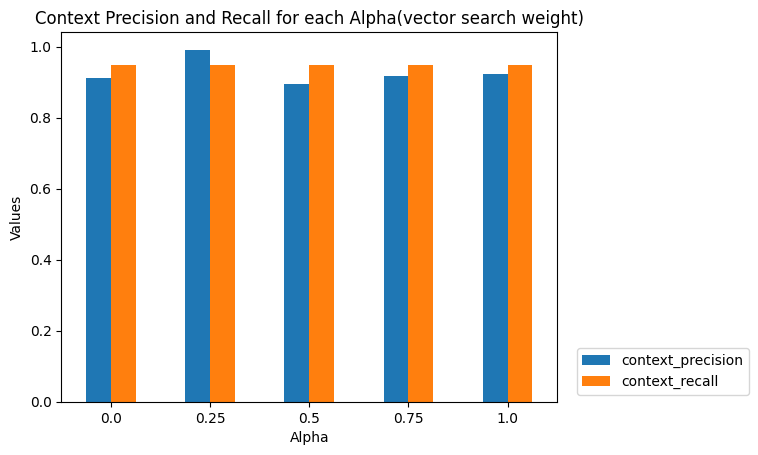

In [85]:
import matplotlib.pyplot as plt

# Create a stacked bar chart
fig, ax = plt.subplots()

# Plotting context_precision and context_recall as stacked bars
mean_metrics_df.plot(kind='bar', x='alpha', y=['context_precision', 'context_recall'], ax=ax)

# Adding labels and title
ax.set_xlabel('Alpha')
ax.set_ylabel('Values')
ax.set_title('Context Precision and Recall for each Alpha(vector search weight)')

ax.legend(loc='lower right', bbox_to_anchor=(1.4, 0))

# Rotate x-axis labels to make them horizontal
plt.xticks(rotation=0)

# Display the stacked bar chart
plt.show()